In [1]:
from ase.io import read
import numpy as np
import os
from tqdm.auto import tqdm

from skmatter.preprocessing import StandardFlexibleScaler
from skmatter.decomposition import PCovR
from rascal.representations import SphericalInvariants as SOAP
from sklearn.linear_model import Ridge
from IPython.display import clear_output
from matplotlib import pyplot as plt
from rascal.models import Kernel

In [2]:
catch = list(
    set([
        '0', '11_2_15848', '12_2_29187', '12_2_32449', '14_2_48453',
        '151_2_4949650', '152_2_118474', '15_2_201714', '169_2_10608',
        '169_2_7915', '207_1_4435', '20_2_26425', '20_2_28176', '2_2_342692',
        '53_3_726600', '58_2_511', '61_2_8842', '67_2_1563', '84_2_1419',
        '91_2_8335121', 'ACO', 'BSV', 'CS-I', 'CS-II', 'DDR', 'HS-III', 'II',
        'III', 'IRR', 'IV', 'IWV', 'IX', 'Ic', 'Ih', 'LTA', 'MAR', 'NON',
        'PCOD8007225', 'PCOD8045578', 'PCOD8047078', 'PCOD8047931',
        'PCOD8172143', 'PCOD8301974', 'PCOD8321499', 'PCOD8324623', 'Q', 'SGT',
        'VI', 'VII', 'VIII', 'X', 'XI', 'XIII', 'XIV', 'XV', 'i'
    ]))
labels = {
    "207_1_4435": 1,
    "12_2_29187_": 2,
    "ACO": 3,
    "LTA": 4,
    "BSV": 5,
    "169_2_7915": 6,
    "53_3_726600": 7,
    "20_2_26425": 8,
    "12_2_32449": 9,
    "84_2_1419": 10,
    "61_2_8842": 11,
    "169_2_10608": 12,
    "PCOD8047078": 13,
    "67_2_1563": 14,
    "PCOD8172143": 15,
    "152_2_118474": 16,
    "DDR": 17,
    "11_2_15848": 18,
    "91_2_8335121": 19,
    "PCOD8301974": 20,
    "PCOD8045578": 21,
    "58_2_511": 22,
    "151_2_4949650": 23,
    "PCOD8007225": 24,
    "2_2_342692": 25,
    "PCOD8321499": 26,
    "PCOD8047931": 27,
    "15_2_201714": 28,
    "MAR": 29,
    "PCOD8324623": 30,
    "SGT": 31,
    "20_2_28176": 32,
    "14_2_48453": 33,
    "NON": 34,
    'quartz': 'Q',
    'Ic_I41md': 'Ic',
    'Ih_Cmc21': 'Ih',
}

In [3]:
frames=read('ice_w_props.xyz', ':')

In [27]:
props = np.asarray([[frm.info['density [g/cm3]'], 
                     frm.info['energy [eV/H2O]'], 
                     frm.info['edr [eV/H2O]']] for frm in frames])

poly_names = np.asarray([frm.info['name'] for frm in frames])

y_scaler = StandardFlexibleScaler(column_wise=True)
y = y_scaler.fit_transform(np.vstack(props[:, 2]))
y2_scaler = StandardFlexibleScaler(column_wise=True)
y2 = y2_scaler.fit_transform(np.vstack(props[:, 1]))

In [4]:
frames = np.asarray(read('ice.xyz', ':'))
for frame in frames:
    frame.wrap(eps=1E-10)

props = np.genfromtxt(
    'ice.dat',
    skip_header=1,
    usecols=(2, 3, 4),
)
poly_names = np.genfromtxt(
    'ice.dat',
    skip_header=1,
    usecols=(0),
    dtype=str,
)

# # take only those shown in the figure or every 10 frames
# i = np.array([ii for ii in range(len(frames)) if poly_names[ii] in catch or ii%10==0])
# frames = frames[i]
# props = props[i]
# poly_names = poly_names[i]
y_scaler = StandardFlexibleScaler(column_wise=True)
y = y_scaler.fit_transform(np.vstack(props[:, 2]))
y2_scaler = StandardFlexibleScaler(column_wise=True)
y2 = y2_scaler.fit_transform(np.vstack(props[:, 1]))

/tmp/ipykernel_3716045/1699946674.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frames = np.asarray(read('ice_w_charges.xyz', ':'))


FileNotFoundError: ice.dat not found.

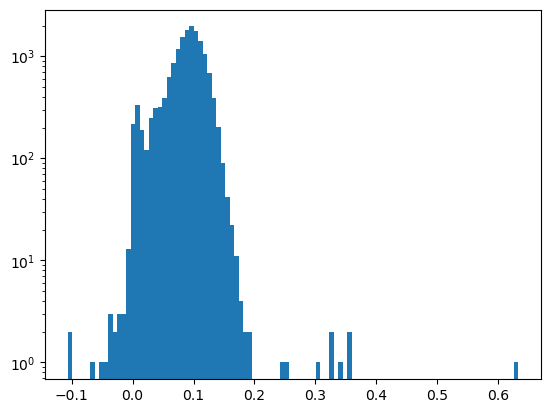

In [15]:
plt.hist(props[:,2], bins=100)
plt.gca().set_yscale('log')
plt.show()

In [16]:
hists = {"HH": [], "OH": [], "OO": []}
bins = np.linspace(0, 7, 100)
bc = 0.5 * (bins[1:] + bins[:-1])

for i, frame in enumerate(tqdm(frames)):
    my_dists = frame.get_all_distances(mic=True)

    nH = len(np.where(frame.numbers == 1)[0])
    nO = len(np.where(frame.numbers == 8)[0])
    nHH = nH * (nH + 1) // 2 - nH
    nOO = nO * (nO + 1) // 2 - nO
    dOO = [
        my_dists[i, j] for i in np.where(frame.numbers == 8)[0]
        for j in np.where(frame.numbers == 8)[0] if i > j
    ]
    assert len(dOO) == nOO
    dHH = [
        my_dists[i, j] for i in np.where(frame.numbers == 1)[0]
        for j in np.where(frame.numbers == 1)[0] if i > j
    ]
    assert len(dHH) == nHH

    hists['HH'].append([np.histogram(dHH, bins=bins)[0], nHH])
    hists['OH'].append([
        np.histogram(my_dists[frame.numbers == 8][:, frame.numbers == 1],
                     bins=bins)[0], nO * nH
    ])
    hists['OO'].append([np.histogram(dOO, bins=bins)[0], nOO])
len(hists["HH"])

  0%|          | 0/15869 [00:00<?, ?it/s]

15869

In [17]:
mult_hist = {k: np.sum([np.multiply(h[0], h[1]) for h in hists[k]], axis=0) / np.sum([h[1] for h in hists[k]]) for k in hists}

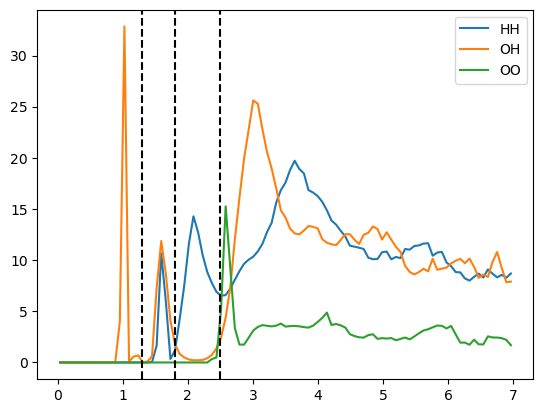

In [18]:
plt.plot(bc, mult_hist["HH"], label='HH')
plt.plot(bc, mult_hist["OH"], label='OH')
plt.plot(bc, mult_hist["OO"], label='OO')
plt.axvline(1.3, c='k', linestyle='--')
plt.axvline(1.8, c='k', linestyle='--')
plt.axvline(2.5, c='k', linestyle='--')
plt.legend()
plt.show()

In [19]:
hists = {"HH": [], "OH": [], "OO": []}
bins = np.linspace(0, 7, 100)
bc = 0.5 * (bins[1:] + bins[:-1])

for i, frame in enumerate(tqdm(frames)):
    my_dists = frame.get_all_distances(mic=False)

    nH = len(np.where(frame.numbers == 1)[0])
    nO = len(np.where(frame.numbers == 8)[0])
    nHH = nH * (nH + 1) // 2 - nH
    nOO = nO * (nO + 1) // 2 - nO
    dOO = [
        my_dists[i, j] for i in np.where(frame.numbers == 8)[0]
        for j in np.where(frame.numbers == 8)[0] if i > j
    ]
    assert len(dOO) == nOO
    dHH = [
        my_dists[i, j] for i in np.where(frame.numbers == 1)[0]
        for j in np.where(frame.numbers == 1)[0] if i > j
    ]
    assert len(dHH) == nHH

    hists['HH'].append([np.histogram(dHH, bins=bins)[0], nHH])
    hists['OH'].append([
        np.histogram(my_dists[frame.numbers == 8][:, frame.numbers == 1],
                     bins=bins)[0], nO * nH
    ])
    hists['OO'].append([np.histogram(dOO, bins=bins)[0], nOO])
len(hists["HH"])

  0%|          | 0/15869 [00:00<?, ?it/s]

15869

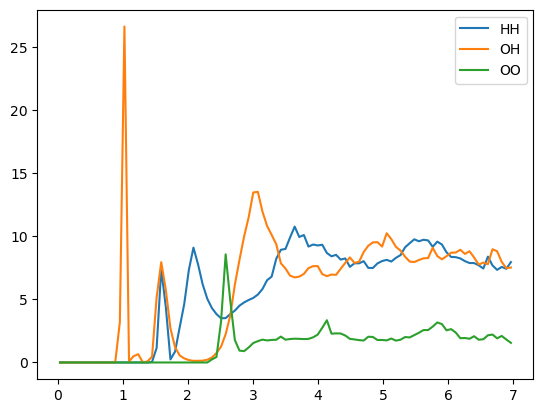

In [20]:
mult_hist = {k: np.sum([np.multiply(h[0], h[1]) for h in hists[k]], axis=0) / np.sum([h[1] for h in hists[k]]) for k in hists}
plt.plot(bc, mult_hist["HH"], label='HH')
plt.plot(bc, mult_hist["OH"], label='OH')
plt.plot(bc, mult_hist["OO"], label='OO')
plt.legend()
plt.show()

In [21]:
for frame in frames:
    mask = np.zeros(len(frame), dtype=bool)
    mask[np.where(frame.numbers==8)] = 1
    frame.arrays['center_atoms_mask'] = mask

In [22]:
hypers = {
    'interaction_cutoff': 5.0,
    'max_radial': 9,
    'max_angular': 6,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.5,
    'radial_basis': 'GTO',
    'normalize': False
}
soap = SOAP(**hypers)
lens = [
    len(
        np.where(
            f.arrays.get('center_atoms_mask', np.ones(len(frame),
                                                             dtype=bool)))[0])
    for f in frames
]
splits = [sum(lens[:i]) for i in range(1, len(lens))]

if not os.path.exists('soaps.npy'):
    manager = soap.transform(frames)
    xa_raw = manager.get_features(soap)
    np.save('soaps.npy', xa_raw)
else:
    xa_raw = np.load('soaps.npy')
i_splits = np.array_split(np.arange(xa_raw.shape[0]), splits)

In [23]:
xa_raw.shape

(224464, 1701)

In [24]:
X_raw = np.array([x.mean(axis=0) for x in np.array_split(xa_raw, splits)])
X = StandardFlexibleScaler(column_wise=False).fit_transform(X_raw)


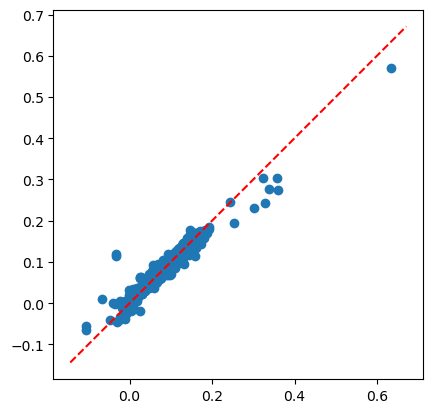

In [28]:
ridge = Ridge(alpha=1E-2).fit(X, y)
yp = ridge.predict(X)
plt.scatter(y_scaler.inverse_transform(y), y_scaler.inverse_transform(yp))
plt.gca().set_aspect('equal')
plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim(), 'r--')

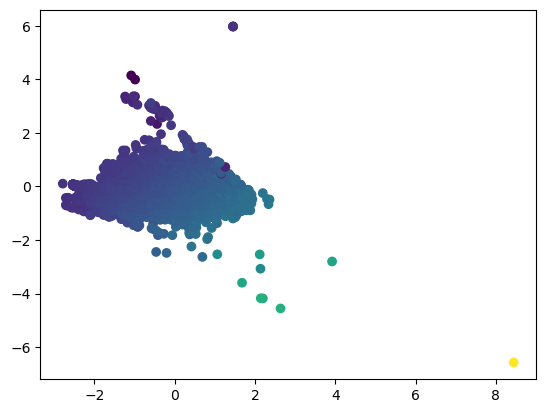

In [35]:
pcovr = PCovR(mixing=0.5, regressor=ridge, n_components=1000)
pcovr.fit(X, y)
t = pcovr.transform(X)
plt.scatter(t[:, 0], t[:, 1], c=y)
plt.show()

In [36]:
if os.path.exists('kernels.npy'):
    K = np.load('kernels.npy')
else:
    K = np.zeros((len(frames), len(frames)))
pbar_tot = tqdm(total=K.shape[0] * K.shape[1])
pbar_tot.update(np.count_nonzero(K))

  0%|          | 0/251825161 [00:00<?, ?it/s]

True

In [ ]:
from sklearn.metrics import pairwise_kernels

def k_func(i):
    k = pairwise_kernels(xa_raw[i_splits[i]],
                         xa_raw[i_splits[i][0]:],
                         metric="cosine")
    k_mean = np.array([np.mean(kk) for kk in np.array_split(k.T, 
                                                          np.subtract(splits[i:], 
                                                                      sum(lens[:i])))])
    del k
    return k_mean

for i in tqdm(range(len(frames))):
    if K[i, -1] == 0:
        K[i, i:] = K[i:, i] = k_func(i)
        pbar_tot.update(2 * (K.shape[0] - i) - 1)
        if any(np.isnan(K[i])):
            print("PROBLEM")
            break
        if i % 100 == 0:
            np.save('kernels.npy', K)

  0%|          | 0/15869 [00:00<?, ?it/s]

In [ ]:
from sklearn.kernel_ridge import KernelRidge as KRR
from skmatter.preprocessing import KernelNormalizer as KN

In [ ]:
k = KN().fit_transform(K)

In [ ]:
krr = KRR(alpha=1E-4, kernel='precomputed')
krr.fit(k, y)
ykp = krr.predict(k)
plt.scatter(y_scaler.inverse_transform(y), y_scaler.inverse_transform(ykp))
plt.gca().set_aspect('equal')
plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim(), 'r--')

In [ ]:
from skmatter.decomposition import KernelPCovR as KPCovR
kpcovr = KPCovR(mixing=0.5, regressor=krr, kernel='precomputed', alpha=1E-4, n_components=1000)
kpcovr.fit(k, y)
tk = kpcovr.transform(k)
plt.scatter(tk[:, 0], tk[:, 1], c=y)
plt.show()

In [ ]:
from skmatter import feature_selection, sample_selection

fFPS = feature_selection.FPS(n_to_select=1000, progress_bar=True).fit(X)
fCUR = feature_selection.CUR(n_to_select=1000, progress_bar=True).fit(X)
fPCovFPS = feature_selection.PCovFPS(mixing=0.0,
                                     n_to_select=1000,
                                     progress_bar=True).fit(X, yp)
fPCovCUR = feature_selection.PCovCUR(mixing=0.0,
                                     n_to_select=1000,
                                     progress_bar=True).fit(X, yp)

In [ ]:
np.savez('feature_selections.npz',
        cur=fCUR.selected_idx_,
        fps=fFPS.selected_idx_,
        pcovcur=fPCovCUR.selected_idx_,
        pcovfps=fPCovFPS.selected_idx_)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
ns = list(sorted(set(np.logspace(0, 3, 100, dtype=int))))
errors = {}
for selector, name in zip(tqdm([fFPS, fCUR, fPCovFPS, fPCovCUR]), ["FPS", "CUR", "PCovFPS", "PCovCUR"]):
    error =np.zeros(len(ns))
    for i, n in enumerate(ns):
        x = X[:, selector.selected_idx_[:n]]
        rr = Ridge(alpha=1E-4).fit(x, y)
        error[i] = mean_squared_error(
            y_scaler.inverse_transform(y),
            y_scaler.inverse_transform(rr.predict(x)))**0.5
    errors[name] = error

In [ ]:
for k in tqdm(range(10)):
    idx = np.random.choice(X.shape[1], 1000)
    error = np.zeros(len(ns))
    for i, n in enumerate(ns):
        x = X[:, idx[:n]]
        rr = Ridge(alpha=1E-4).fit(x, y)
        error[i] = mean_squared_error(
            y_scaler.inverse_transform(y),
            y_scaler.inverse_transform(rr.predict(x)))**0.5
    errors[f'random_{k}'] = error

In [ ]:
rr = Ridge(alpha=1E-4).fit(X, y)
ferror = mean_squared_error(y_scaler.inverse_transform(y), y_scaler.inverse_transform(rr.predict(X)))**0.5
ferror

In [ ]:
colors = {
    "FPS": 'dodgerblue',
    'CUR': 'crimson',
    'PCovFPS': 'dodgerblue',
    'PCovCUR': 'crimson'
}
linestyles = {"FPS": "dashed", "CUR": "dashed", "PCovFPS": "solid", "PCovCUR":"solid"}
for name in ["FPS", "CUR", "PCovFPS", "PCovCUR"]:
    plt.loglog(ns, errors[name], label=name, c=colors.get(name), linestyle=linestyles.get(name))
plt.errorbar(
    ns,
    np.mean([errors[f'random_{i}'] for i in range(10)], axis=0),
    np.std([errors[f'random_{i}'] for i in range(10)], axis=0),
    c='k', errorevery=10,
    label='Random (10 trials)'
)
plt.axhline(ferror,
            c='grey',
            linestyle='dashed',
            label='All Features',
           )
plt.legend()
plt.show()

In [ ]:
if os.path.exists('selected_kernels.npz'):
    Ks = dict(np.load('selected_kernels.npz'))
else:
    Ks = {str(n): np.zeros((len(frames), len(frames))) for n in ns[::10]}
pbar_tot = tqdm(total=X.shape[0] * X.shape[1] * len(list(Ks.keys())))

In [ ]:
from sklearn.metrics import pairwise_kernels

def k_func_sel(i, idx):
    k = pairwise_kernels(xa_raw[i_splits[i]][:,idx],
                         xa_raw[i_splits[i][0]:][:,idx],
                         metric="cosine")
    k_mean = np.array([np.mean(kk) for kk in np.array_split(k.T, 
                                                          np.subtract(splits[i:], 
                                                                      sum(lens[:i])))])
    del k
    return k_mean

for n in Ks:
    for i in tqdm(range(len(frames))):
        if Ks[str(n)][i, -1] == 0:
            Ks[str(n)][i, i:] = Ks[str(n)][i:, i] = k_func_sel(i, fPCovCUR.selected_idx_[:int(n)])
            pbar_tot.update(2 * (Ks[str(n)].shape[0] - i) - 1)
            if any(np.isnan(Ks[str(n)][i])):
                print("PROBLEM")
                break
            if i % 1000 == 0:
                np.savez('selected_kernels.npz', **Ks)

In [ ]:
from chemiscope import show

In [ ]:
known = np.zeros(len(frames), dtype=bool)
known[:17] = True
widget = show(frames,
                properties={
                    "pcovr": t,
                    "kpcovr": tk,
                    "e_dr [eV/H2O]": props[:, 2],
                    "e_dr [scaled]": y,
                    "predicted e_dr [scaled]": yp,
                    "kpredicted e_dr [scaled]": ykp,
                    "y error": np.abs(y-yp),
                    "ky error": np.abs(y-ykp),
                    "density [g/cm3]": props[:, 0],
                    "name": poly_names,
                    "labeled": [n in catch for n in poly_names],
                    "known": known
                })

In [ ]:
widget.save('ice.json')